# Case Study: Model Suitability

## Aim: Can I use a given model on a given dataset

We often find ourselves in a situation where we have a pre-trained model for a certain task (e.g. cardiac segmentation) and we have a data set where we want to perform that task. We know the model was not trained on that specific dataset. So we wonder, how will the model perform? Is it usable at all? Do we need to pre-process our data in a certain way to use it?

In this case study we demonstrate how `misas` helps answer these questions with a concrete example:
 - **Model**: [`ukbb_cardiac` network](https://github.com/baiwenjia/ukbb_cardiac) by [Bai et al. 2018 [1]](https://doi.org/10.1186/s12968-018-0471-x), trained on [UK Biobank](https://www.ukbiobank.ac.uk/) cardiac MRI images
 - **Data**: Kaggle [Data Science Bowl Cardiac Challenge Data](https://www.kaggle.com/c/second-annual-data-science-bowl) MRI images

## Prepare Model for `misas`

The used model was trained on UK Biobank cardiac imaging data to segment short-axis images of the heart into left ventricle (LV), right ventricle (RV) and myocardium (MY). For details about the model please read [the paper (Bai et al. 2018)](https://doi.org/10.1186/s12968-018-0471-x) and cite it if you use it. For implementation, training and usage see the [GitHub repository](https://github.com/baiwenjia/ukbb_cardiac). We downloaded the pre-trained model for short-axis images from https://www.doc.ic.ac.uk/~wbai/data/ukbb_cardiac/trained_model/ (local copy in `example/kaggle/FCN_sa`). In order to use it with `misas` we need to wrap it in a class that implements the desired interface (`prepareSize` and `predict` taking `Image` as input, see the main docu for more details).

`ukbb_cardiac` is written in `tensorflow` v1. With `tensorflow` v2 make sure to import the compat module.

In [ ]:
import tensorflow.compat.v1 as tf

The model requires images to be a multiple of 16 in each dimension. We pad images accordingly in `prepareSize`. Additionally code in `image_to_input` takes care of the specifics of transforming a three-channel image into a single-item batch of single-channel images. In `predict` the output is converted to `ImageSegment` class.

In [ ]:
class ukbb_model:
    def __init__(self, model_path):
        tf.disable_eager_execution()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(f'{model_path}.meta')
        saver.restore(self.sess, model_path)
        
    def prepareSize(self, image):
        _, X, Y = image.shape
        image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
        return image
    
    def image_to_input(self, image):
        img = image.clone()
        self.prepareSize(img)
        img_data = img.data[0]
        img_data = np.expand_dims(img_data, 0)
        img_data = np.expand_dims(img_data, -1)
        return img_data
    
    def predict(self, image):
        image_data = self.image_to_input(image)
        preds, classes = self.sess.run(['prob:0', 'pred:0'],
                   feed_dict={'image:0': image_data, 'training:0': False})
        preds = np.squeeze(preds, 0)
        classes = ImageSegment(ByteTensor(classes))
        return classes, preds
        

In [ ]:
model = ukbb_model('example/kaggle/FCN_sa')

INFO:tensorflow:Restoring parameters from example/kaggle/FCN_sa


## Prepare Dataset for `misas`

The [Data Science Bowl Cardiac Challenge Data](https://www.kaggle.com/c/second-annual-data-science-bowl) consists of MRI cine images from 1140 patients in dicom format. Multiple slices in short axis are available for each patient. Additionally, end-systolic and end-diastolic volumes are given (the original Kaggle challenge asked participants to predict these from the images).

You can download and unpack the dataset from the above website. Some example images are included in the `example/kaggle/dicom` folder.

We use `fastai2.medical.imaging` to read the images and convert them to fastai v1 `Image` objects.

In [ ]:
from fastai.vision import *
from fastai2.medical.imaging import dcmread

We use the window information within the dicom file to scale pixel intensities accordingly.

In [ ]:
def read_dcm(fname):
    dcm = Path(fname).dcmread()
    pixels = (dcm.pixels.windowed(dcm.WindowWidth, dcm.WindowCenter)).unsqueeze(0)
    pixels = torch.cat((pixels,pixels,pixels), dim=0)
    return Image(pixels)

Okay, let's look at an example:

torch.Size([3, 256, 192])

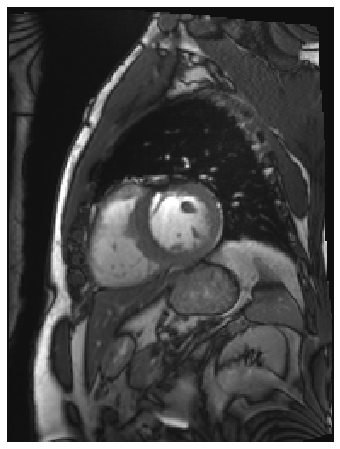

In [ ]:
img = read_dcm("kaggle/train/117/sax_76/IM-11654-0005.dcm")
img.show(figsize=(8,8))
img.shape

## How does the model perform out of the box?

Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

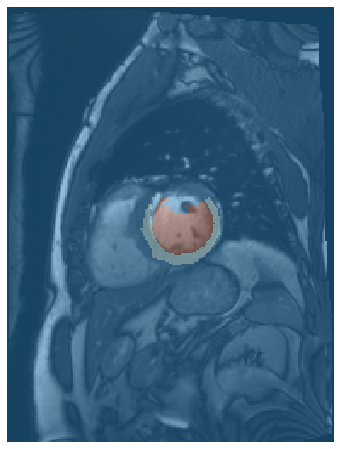

In [ ]:
img = model.prepareSize(img)
img.show(figsize=(8,8), y=model.predict(img)[0])

The model identified the left ventricle and myocardium partially. It failed to identify the right ventricle. So this result is promising in that it shows some kind of success but it is not usable as it is.

> Note: This is neither surprising nor a critique on the `ukbb_cardiac` network. That network was trained specifically for UK Biobank images and not to be applied generally.

Still, we might be able to use it on the kaggle dataset if we understand why it fails and properly pre-process the data. This is where `misas` comes in. But first look at some more examples to see if we selected a bad example by chance.

In [ ]:
from glob import glob
dcm_files = glob("kaggle/train/*/sax_*/*.dcm")

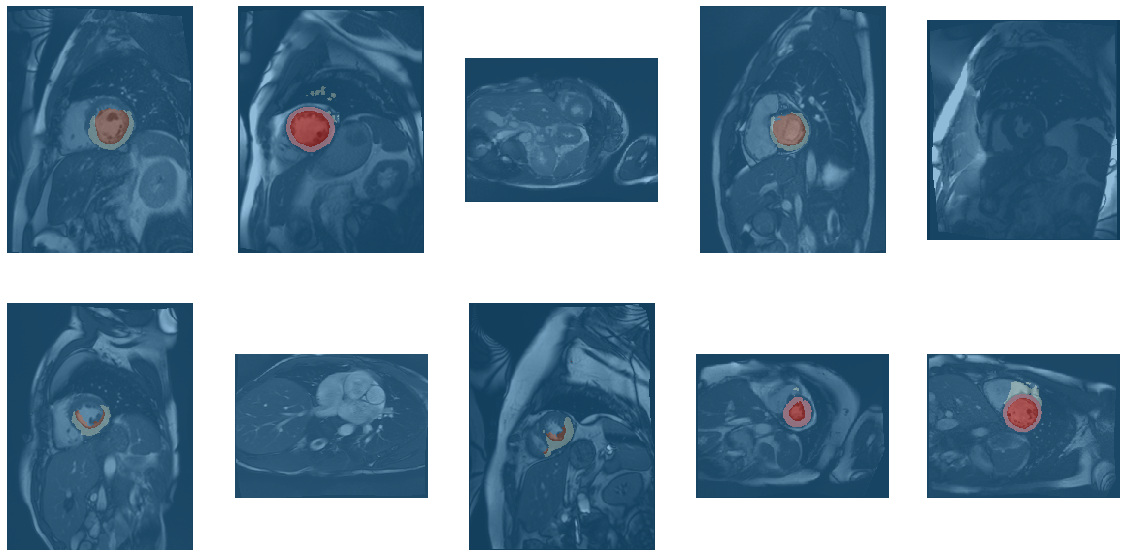

In [ ]:
random.seed(42)
fig, axs = plt.subplots(2,5, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    tmp = model.prepareSize(read_dcm(dcm_files[random.randint(0,len(dcm_files)-1)]))
    tmp.show(ax=ax, y=model.predict(tmp)[0])

Apparently our first impression that it does not work out of the box applies to most images. This also shows a bit of the variety of images and quality and also some inconsistencies in orientation.

> Warning: Class colors might not be consistent if some class is completely missing from the prediction

## Analysis of one image

In [ ]:
from misas.core import *

### Sensitivity to orientation

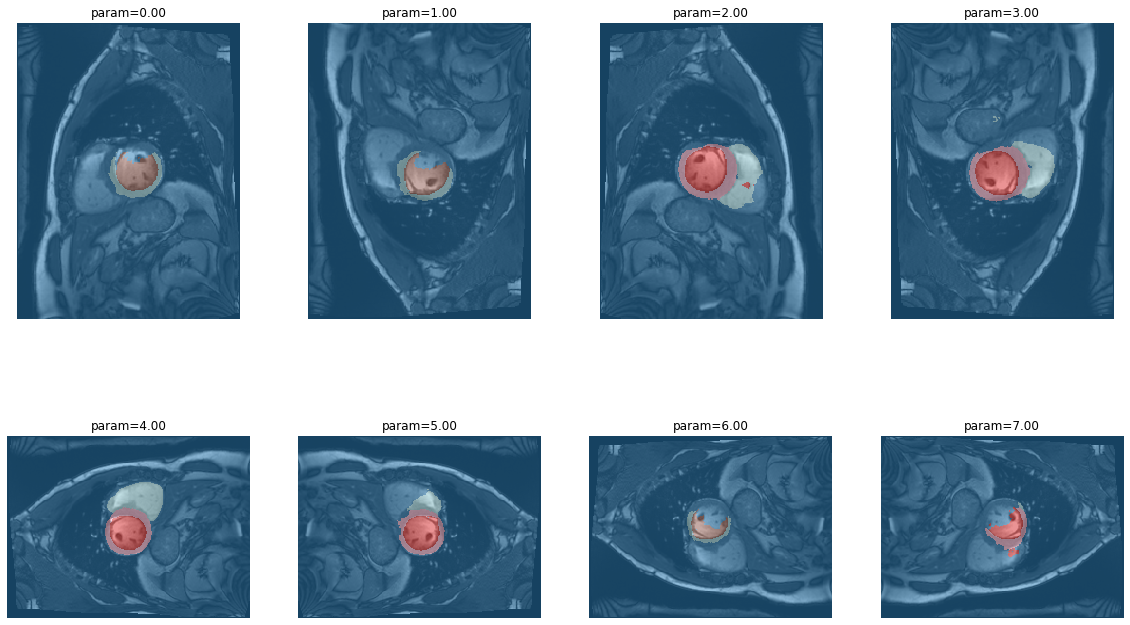

In [ ]:
plot_series(get_dihedral_series(img,model), nrow=2, figsize=(20,12))

Example of applying dihedral transformation function

In [ ]:
img = lambda: open_image("example/kaggle/images/1-frame014-slice006.png")
trueMask = lambda: open_mask("example/kaggle/masks_full/1-frame014-slice006.png")

Without flipping and rotating network doesn't recognize heart (image "param = 0.00"). Dihedral transformation was applied. It helps transpond the image to the same coordinate axes as those of the images on which the neural network was trained. The best prediction was obtained after one image transposition and one flip (image "param = 5.00")

In [ ]:
results = eval_dihedral_series(img(),trueMask(),model,components=["bg","LV","MY","RV"])

In [ ]:
import altair as alt

In [ ]:
(alt
 .Chart(results.melt(id_vars=['k'],value_vars=['LV','MY','RV']))
 .mark_circle(size=60)
 .encode(
     x="k",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
def prep_with_dihedral(image):
    image = image.clone()
    _, X, Y = image.shape
    image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
    return image.dihedral(5)

In [ ]:
model.prepareSize = prep_with_dihedral

### Sensitivity to resize

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


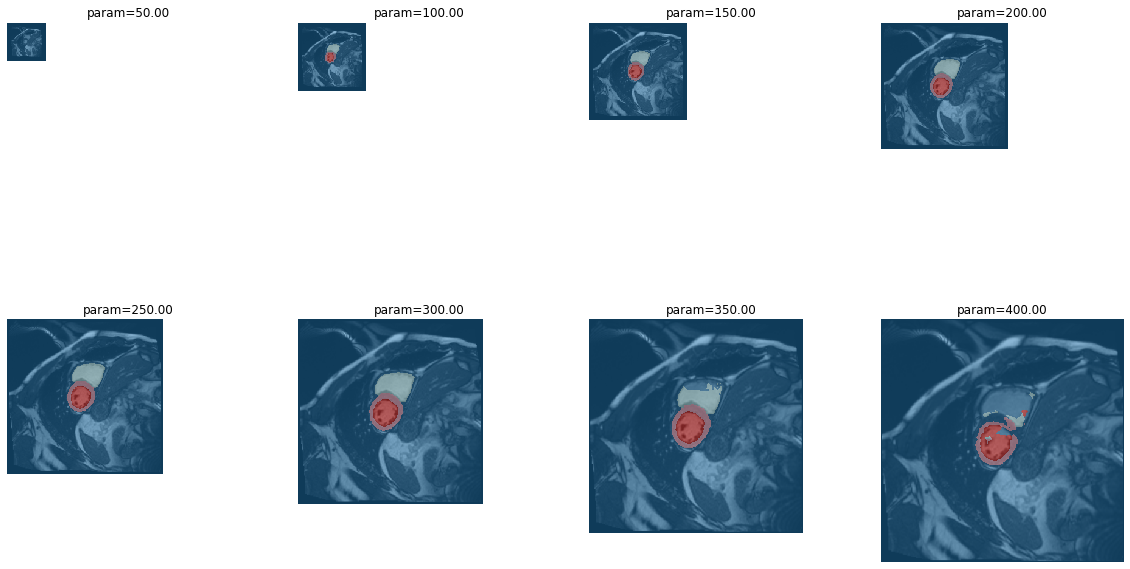

In [ ]:
plot_series(get_resize_series(img(),model, start=50, end=401,step=50), sharex=True, sharey=True, figsize=(20,10), nrow=2)

In [ ]:
results = eval_resize_series(img(),trueMask(),model,end=600,step=30, components=["bg","LV","MY","RV"])

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
(alt
 .Chart(results.melt(id_vars=['px'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="px",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs = get_resize_series(img(),model, start=50, end=401,step=50)

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
imgs

[[50, Image (3, 64, 64), ImageSegment (1, 64, 64), None],
 [100, Image (3, 112, 112), ImageSegment (1, 112, 112), None],
 [150, Image (3, 160, 160), ImageSegment (1, 160, 160), None],
 [200, Image (3, 208, 208), ImageSegment (1, 208, 208), None],
 [250, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [300, Image (3, 304, 304), ImageSegment (1, 304, 304), None],
 [350, Image (3, 352, 352), ImageSegment (1, 352, 352), None],
 [400, Image (3, 400, 400), ImageSegment (1, 400, 400), None]]

In [ ]:
padded_imgs = [[x[0], x[1].crop_pad(400, padding_mode="zeros"), x[2].crop_pad(400, padding_mode="zeros")] for x in imgs]

In [ ]:
gif_series(
    padded_imgs,
    "example/kaggle/resize_ukbb.gif",
    param_name="size",
    duration=400
)

![segmentation sensitivity to resizing](example/kaggle/resize_ukbb.gif)

**TODO: add prep_with_dihedral_and_resize**

### Sensitivity to rotation

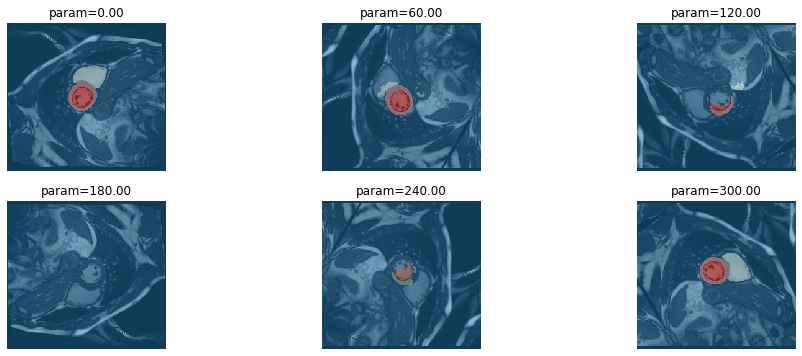

In [ ]:
plot_series(get_rotation_series(img(),model), nrow=2)

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs1 = get_rotation_series(img(),model, start=1, end=360,step=10)

In [ ]:
imgs1

[[1, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [11, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [21, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [31, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [41, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [51, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [61, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [71, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [81, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [91, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [101, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [111, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [121, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [131, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [141, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [151, Image (3, 240, 256), ImageSegment (1, 240, 256), None],
 [1

In [ ]:
gif_series(
    imgs1,
    "example/kaggle/rotation_ukbb.gif",
    param_name="deg",
    duration=400
)

![segmentation sensitivity to rotation](example/kaggle/rotation_ukbb.gif)

In [ ]:
from IPython.display import Image as im

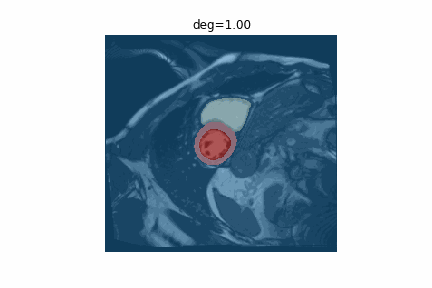

In [ ]:
im("example/kaggle/rotation_ukbb.gif")

![segmentation sensitivity to rotation](example/kaggle/rotation_ukbb.gif)

### Sensitivity to cropping

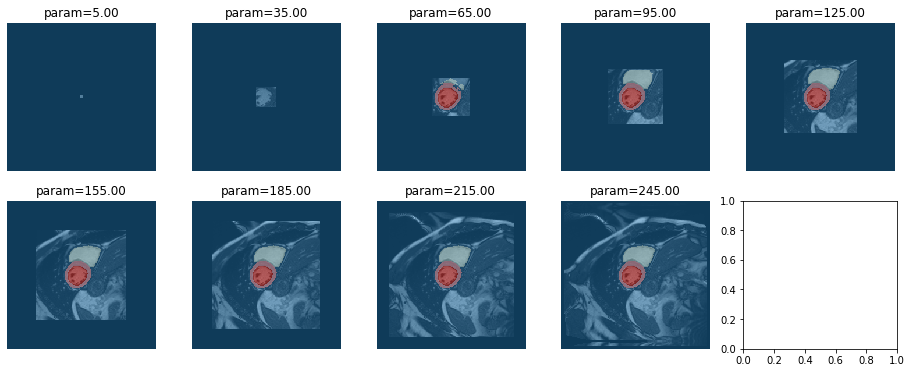

In [ ]:
plot_series(get_crop_series(img(),model, start = 5, step = 30), nrow=2)

In [ ]:
results = eval_crop_series(img(),trueMask(),model,start = 5, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs1 = get_crop_series(img(),model, start=250, end=5,step=-10)

In [ ]:
gif_series(
    imgs1,
    "example/kaggle/crop_ukbb.gif",
    param_name="pixels",
    duration=400
)

![segmentation sensitivity to rotation](example/kaggle/crop_ukbb.gif)

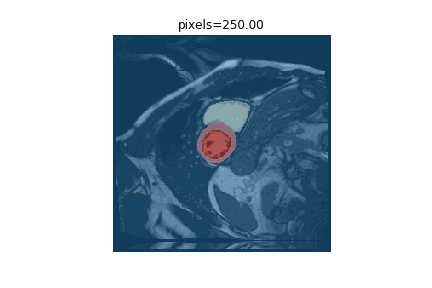

In [ ]:
im("example/kaggle/crop_ukbb.gif")

### Sensitivity to brightness

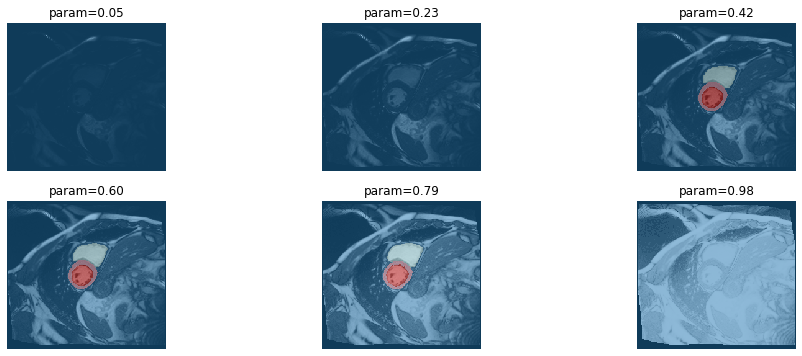

In [ ]:
plot_series(get_brightness_series(img(),model, end = 0.99, step = 0.185), nrow=2)

In [ ]:
results = eval_bright_series(img(),trueMask(),model, end = 0.99, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs1 = get_brightness_series(img(),model, start=0.05, end=0.95,step=0.05)

In [ ]:
gif_series(
    imgs1,
    "example/kaggle/bright_ukbb.gif",
    param_name="brightness",
    duration=400
)

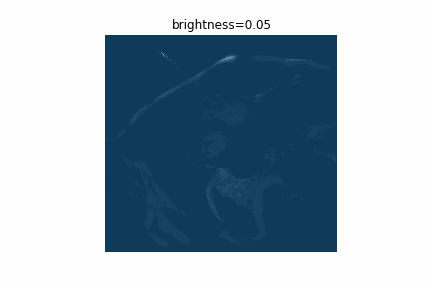

In [ ]:
im("example/kaggle/bright_ukbb.gif")

### Sensitivity to contrast

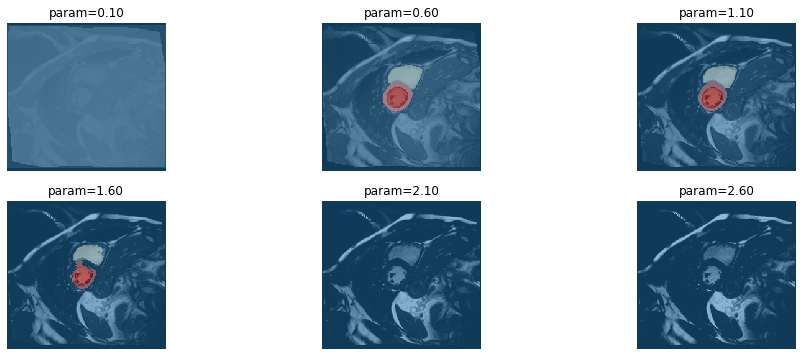

In [ ]:
plot_series(get_contrast_series(img(),model, start=0.1, end=3, step=0.5), nrow = 2)

In [ ]:
results = eval_contrast_series(img(),trueMask(),model, end = 2.5, step = 0.3, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs1 = get_contrast_series(img(),model, start=0.05, end=2.2,step=0.1)

In [ ]:
gif_series(
    imgs1,
    "example/kaggle/contrast_ukbb.gif",
    param_name="contrast",
    duration=400
)

![segmentation sensitivity to contrast](example/kaggle/contrast_ukbb.gif)

### Sensitivity to zoom

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


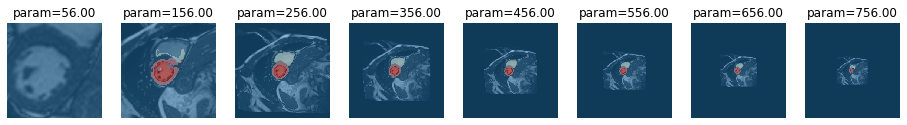

In [ ]:
plot_series(get_zoom_series(img(),model,end=850,step=100))

In [ ]:
results = eval_zoom_series(img(),trueMask(),model,end=1000,step=100,components=["bg","LV","MY","RV"])

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs1 = get_zoom_series(img(),model, start=50, end=900,step=50)

/home/shainberg/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
gif_series(
    imgs1,
    "example/kaggle/zoom_ukbb.gif",
    param_name="scale",
    duration=400
)

![segmentation sensitivity to zoom](example/kaggle/zoom_ukbb.gif)

[1] W. Bai, et al. Automated cardiovascular magnetic resonance image analysis with fully convolutional networks. Journal of Cardiovascular Magnetic Resonance, 20:65, 2018.